In [1]:
import sympy as sy
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# ORIGINAL PARAMETERS #

p = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
kd = 8993 # (methionine dissociation constant)
h = j / kd #'' # per micromolar per millisecond (methionine binding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
u = 1 # per millisecond (ubiquitination rate)
a = 10 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
d = .002 #'' # per millisecond (degradation rate)
n = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 174333.33 # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
        # can range from 0 to infty
Km = 350 #'' # micromolars (methionin michaelis-menten constant)
# vmax = 8.8e3
# Km = 2.5
Me = .1


In [4]:
# change a parameter
vmax = -1

In [5]:
# substitution into M to get equation for bisection method

# establish sympy variables
P, Pm, Pa, Pu, E, Em, Ea, Eu, M = sy.symbols("P, Pm, Pa, Pu, E, Em, Ea, Eu, M")

# steady states computed previously
steady_states = {P : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                 Pm : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                 Pa : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                 Pu : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                 E : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                 Em : Ap*p*(b + d)/(Ae*a*d),
                 Ea : Ap*p*(b + d)/(Ae*d*u),
                 Eu : Ap*p/(Ae*d)}

# substitutions
dM = -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 

new_dM = dM.subs(steady_states)
new_dM = sy.simplify(new_dM)
new_dM

(-10.7748116*M**3 - 97153.0956589924*M**2 - 29222614.9945766*M + 1168885922.77476)/(M*(523.0*M**2 + 184723.6*M + 585760.0))

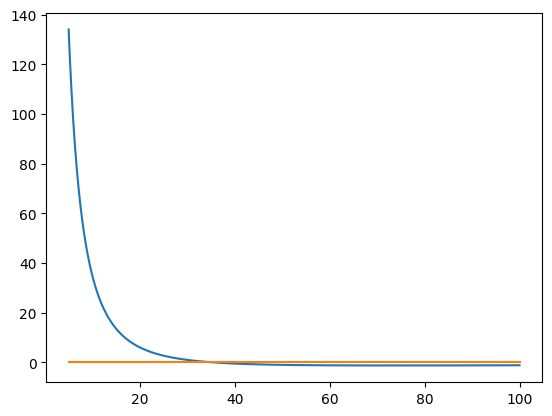

In [6]:
dM_func = sy.lambdify(M, new_dM)

# plot dM against M
x_vals = np.linspace(5, 100, 1000)
plt.plot(x_vals, dM_func(x_vals))
plt.plot(x_vals, np.zeros_like(x_vals))
# plt.ylim(-10, 10)
plt.show()

In [2]:
"""Define the model"""
from mup1_model import bisection_M

def mup1_model(t, y, parameters):
    """Function coding the Mup1 trafficking model.
    
        Parameters:
        - y (array, list): values of P, Pm, Pa, Pu, E, Em, Ea, Eu, M"""

    P, Pm, Pa, Pu, E, Em, Ea, Eu, M = y 
    p, w, j, kd, h, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability

    # define the differential equations
    dy = [
        p - h*Me*P - (h/w)*M*P + j*Pm + f*(Ae/Ap)*E,                       # P
        h*Me*P + (h/w)*M*P - j*Pm - a*Pm,                                 # Pm
        a*Pm - u*Pa,                                                      # Pa
        u*Pa - n*Pu,                                                      # Pu
        n*(Ap/Ae)*Pu - f*E + b*Eu - (h/w)*E*M + j*Em,                      # E
        (h/w)*E*M - a*Em - j*Em,                                          # Em
        a*Em - u*Ea,                                                      # Ea
        -b*Eu + u*Ea - d*Eu,                                             # Eu
        -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 
        ]

    return dy

def mup1_steady_states(parameters):
    """Function to find the steady states of the Mup1 trafficking model.
    
        Parameters:
        - parameters (array, list): values of the parameters"""
    p, w, j, kd, h, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability
    M = bisection_M(Me)

    steady_states = {'P' : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                    'Pm' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                    'Pa' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                    'Pu' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                     'E' : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                    'Em' : Ap*p*(b + d)/(Ae*a*d),
                    'Ea' : Ap*p*(b + d)/(Ae*d*u),
                    'Eu' : Ap*p/(Ae*d)}
    

    return sum(steady_states.values()) + M

In [3]:
"""Parameter Sensitivity Analysis"""
from SALib.sample import saltelli, sobol as sobol_sample
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# set up problem
problem = {
    'num_vars': 16,
    'names': ['p', 'w', 'j', 'kd', 'h', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km'],
    'bounds': [[8e-5, 8.5e-5],
               [30, 34],
               [50, 150],
               [2182, 9102],
               [50, 150],
               [.1, .5],
               [30, 60],
               [250, 350],
               [.5, 2],
               [5, 15],
               [.5, 2],
               [.001, .003],
               [.001, .2],
               [475, 575],
               [100, 500000],
               [10, 500]]
}

# generate samples using Saltelli sampler
param_values = sobol_sample.sample(problem, 128)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

# set up for use with solve_ivp
# Choose initial conditions
y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time span for integration
t_span = (0, 50)
t_eval = np.linspace(*t_span, 10)

for i, X in enumerate(tqdm(param_values, desc="Running model")):
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    # have it save the total amount of mup1
    Y[i] = sum(sol.y[:, -1])

# compute sensitivity indices using model outputs
Si = sobol.analyze(problem, Y)

Si.plot()
plt.show()


Running model:   0%|          | 0/4352 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 17, got 16)

Starting multiprocessing


Running model in parallel:   0%|          | 0/576 [00:00<?, ?it/s]

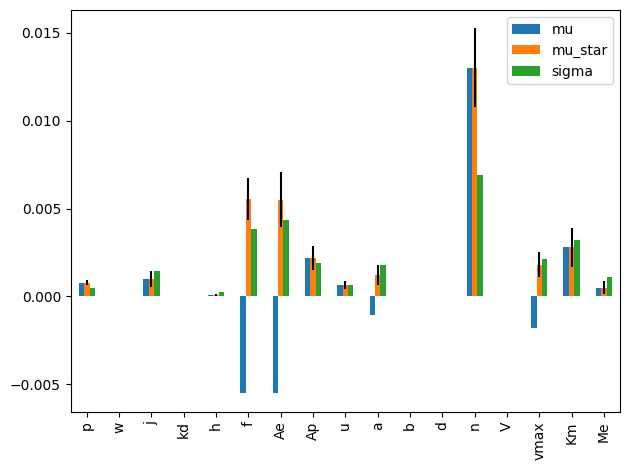

In [6]:
"""Trying it again using multiprocessing"""

from multiprocessing import Pool
from SALib.sample import sobol as sobol_sample, morris as morris_sample
from SALib.analyze import sobol, morris
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# set up problem
problem = {
    'num_vars': 17,
    'names': ['p', 'w', 'j', 'kd', 'h', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me'],
    'bounds': [[8e-5, 8.5e-5],
               [30, 34],
               [50, 150],
               [2182, 9102],
               [50, 150],
               [.1, .5],
               [30, 60],
               [250, 350],
               [.5, 2],
               [5, 15],
               [.5, 2],
               [.001, .003],
               [.001, .2],
               [475, 575],
               [100000, 500000],
               [10, 500],
               [.1, 20]]
}

# generate samples using Saltelli sampler
param_values = morris_sample.sample(problem, 32)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

def run_model(X):
    # set up for use with solve_ivp
    y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 10)
    
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    return sum(sol.y[:, -1])

print("Starting multiprocessing")
# Use multiprocessing to run the model in parallel
with Pool() as pool:
    # Use map instead of imap to maintain order
    Y = list(tqdm(pool.imap(run_model, param_values), 
                    total=len(param_values),
                    desc="Running model in parallel"))

# Convert to numpy array
Y = np.array(Y)

# compute sensitivity indices using model outputs
Si = morris.analyze(problem, param_values, Y)

Si.plot()
plt.tight_layout()
plt.savefig("sensitivity_analysis_morris_reduced_vmax_3.png")
plt.show()



In [5]:
print(Si)

{'names': array(['p', 'w', 'j', 'kd', 'h', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n',
       'V', 'vmax', 'Km', 'Me'], dtype='<U4'), 'mu': masked_array(data=[0.14172381389942185, 0.1721237898514752,
                   1.3950771003621076, 0.0, -1.4361781819235522,
                   1.8668097324829036, -0.6549477215165088,
                   0.3225214337139605, -0.6249702185942169,
                   -1.3710886709741386, 2.384118951672787,
                   -2.406594317123489, -4.079290401351, 0.0, 0.0, 0.0,
                   8.892627380540683],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False],
       fill_value=1e+20), 'mu_star': masked_array(data=[0.14172381389942185, 0.1721237898514752,
                   1.3950771003621076, 0.0, 1.4361781819235522,
                   1.8668097324829036, 0.6549477215165088,
                   0.3225214337139605, 0.6249702185